In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.decomposition import PCA

In [2]:
# Load data

train = pd.read_table("data/datatraining.txt", sep = ',')
train.index = pd.to_datetime(train.date)
train = train.drop('date', axis = 1)

test = pd.read_table("data/datatest.txt", sep = ",")
test.index = pd.to_datetime(test.date)
test = test.drop('date', axis = 1)

In [3]:
# Remove and save known anomalies from training data, save known anomalies from testing data

y_train = train.Occupancy
train_no_anomalies = train[train.Occupancy == 0].drop('Occupancy', axis = 1)
train_anomalies = train.drop('Occupancy', axis = 1)

y_test = test.Occupancy
test = test.drop('Occupancy', axis = 1)

In [4]:
# Preprocessing Functions

def normalize_data(train, train_full, test):
    
    norm_train = (train - train.mean()) / train.std()
    norm_train_full = (train_full - train.mean()) / train.std()
    norm_test = (test - train.mean()) / train.std()
    
    return norm_train, norm_train_full, norm_test

def generate_PCA(train, train_full, test, n_components):
    
    pca = PCA(n_components = n_components, svd_solver = 'full')

    pca_train = pd.DataFrame(pca.fit_transform(train))
    pca_train.index = train.index
    
    pca_train_full = pd.DataFrame(pca.fit_transform(train_full))
    pca_train_full.index = train_full.index

    pca_test = pd.DataFrame(pca.transform(test))
    pca_test.index = test.index
    
    return pca_train, pca_train_full, pca_test

In [5]:
norm_train, norm_train_anomalies, norm_test = normalize_data(train_no_anomalies, train_anomalies, test)

pca_train, pca_train_anomalies, pca_test = generate_PCA(norm_train, norm_train_anomalies, norm_test, 2)

In [6]:
# Functions to calculate Mahalanobis Distance

def inv_cov_matrix(x):
    cov = np.cov(x.T)
    if np.all(np.linalg.eigvals(cov) > 0):
        return(np.linalg.inv(cov))

def calculate_M_distance(inv_cov_matrix, means, data):
    diff = data - means
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_cov_matrix).dot(diff[i])))
    return md

def detect_outliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)
    return np.array(outliers)

def calculate_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [19]:
# Find Mahalanobis Distance

x_train = np.array(pca_train.values)
x_train_anomalies = np.array(pca_train_anomalies.values)
x_test = np.array(pca_test.values)

inv_cov_train = inv_cov_matrix(x_train)

means = x_train.mean(axis=0)

mdist_train = calculate_M_distance(inv_cov_train, means, x_train)
mdist_train_anomalies = calculate_M_distance(inv_cov_train, means, x_train_anomalies)
mdist_test = calculate_M_distance(inv_cov_train, means, x_test)

threshold = calculate_threshold(mdist_train, extreme = True)

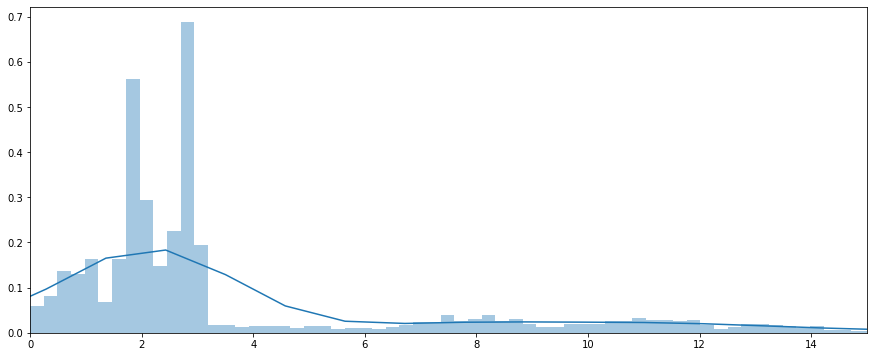

In [20]:
plt.figure(figsize=(15, 6))
sns.distplot(np.square(mdist_train_anomalies),
             bins = 400)
plt.xlim([0.0,15]);

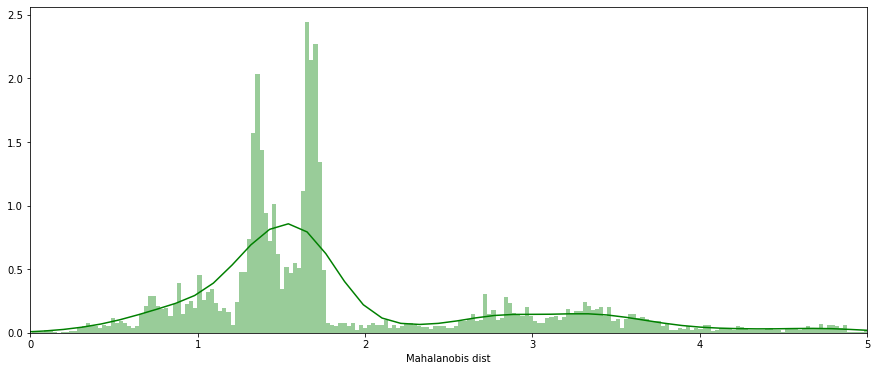

In [21]:
plt.figure(figsize=(15, 6))
sns.distplot(mdist_train_anomalies,
             bins = 400, 
             color = 'green')
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist');

In [22]:
# Label anomalies

train_anomaly = pd.DataFrame()
train_anomaly['Mob dist']= mdist_train_anomalies
train_anomaly['Thresh'] = threshold
train_anomaly['Anomaly'] = train_anomaly['Mob dist'] > train_anomaly['Thresh']
train_anomaly.index = pca_train_anomalies.index

anomaly = pd.DataFrame()
anomaly['Mob dist']= mdist_test
anomaly['Thresh'] = threshold
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = pca_test.index

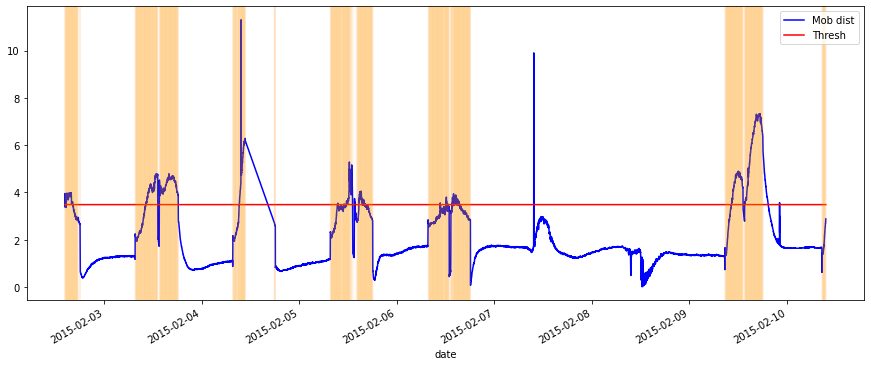

In [23]:
all_anomalies = pd.concat((train_anomaly, anomaly))
y = pd.concat((y_train, y_test))

all_anomalies.plot(figsize = (15,6), color = ['blue','red'], legend = True)

anoms = list(y.index[y == 1])
for a in anoms:
    plt.axvline(a, color='orange', alpha=0.02)